In [53]:
@time using Plots
@time using Images
@time using ColorSchemes
@time using StatsBase
@time using LsqFit

  0.000208 seconds (356 allocations: 18.781 KiB)
  0.000169 seconds (286 allocations: 15.250 KiB)
  0.000157 seconds (226 allocations: 12.219 KiB)
  0.000164 seconds (406 allocations: 21.344 KiB)


┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1260


 91.422547 seconds (14.13 M allocations: 699.526 MiB, 0.28% gc time)


In [7]:
printArray(arr) = Base.print_matrix(IOContext(stdout, :limit => true), arr)

printArray (generic function with 1 method)

In [8]:
function neighbourIndices(nType::Int64, rad::Int64)
    indices = []
    if(nType == 0)
        indices = vcat([[i, 0] for i in -rad:rad], [[0, j] for j in -rad:rad])
    elseif(nType == 1)
        indices = [[i, j] for i in -rad:rad for j in -rad:rad]
    elseif(nType == 2)
        indices = [[i, j] for j in -rad:rad for i in (abs(j) - rad):(rad - abs(j))]
    end
    
    indices = [CartesianIndex(ind...) for ind in setdiff(indices, [[0,0]])]
end

neighbourIndices (generic function with 1 method)

In [9]:
function colormap(z0, cType)
    if cType == 1
        colors = range(RGB{N0f8}(0.0,0.0,0.0), stop=RGB{N0f8}(0,0.8,0.8), length = z0+5)
    end
    
    cmap = Dict(zip(0:z0+4, colors))
end

colormap (generic function with 1 method)

In [10]:
function setInitConditions(grid, init, z0, indices)
    if(init[1] == "random")
        for ind in indices
            grid[ind] = rand(0:z0-1 .|> Int8)
        end
        
    elseif(init[1] == "uniform")
        grid[indices] .+= init[2]
    end
    
    return
end

setInitConditions (generic function with 1 method)

In [11]:
function makegif(frames, z0, nsteps, fname, pType)
    if(pType == "h") #heatmap
        cmap = colormap(z0+4, 1)
        animGIF = @animate for i ∈ 1:nsteps 
            plot([cmap[p] for p in frames[i]])
        end
        gif(animGIF, fname, fps = 15)
        
    elseif(pType == "w") #wireframe
        animGIF = @animate for i ∈ 1:nsteps 
            plot(frames[i], st = :wireframe, zlims = (0, z0+4), camera = (-30, 35))
        end
        gif(animGIF, fname, fps = 15)        
    end
end

makegif (generic function with 1 method)

In [12]:
function Sandpile(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
    sandbox = zeros(Int8, (n + 2*rad, n + 2*rad)) #main simulation grid
    frames = [] #stores each frame
    
    relNeighbour = neighbourIndices(2, rad) #relative index of neighbours
    indices = [CartesianIndex(i,j) for i in (rad+1):(n+rad) for j in (rad+1):(n+rad)] #accessible nodes
    borders = filter(x -> !(x in indices), CartesianIndices(sandbox)) #inaccessible nodes /fixed BC
    
    #initial conditions
    setInitConditions(sandbox, init, z0, indices)
    
    #boundary conditions; fixed
    sandbox[borders] .= bValue
    
    prev = copy(sandbox) #copy of the grid
    push!(frames, copy(sandbox))
    
    for k in 2:nsteps
        
        #external driving
        if (sandbox[drop...] < z0) 
            sandbox[drop...] += 1
            prev[drop...] += 1
        end
        
        for index in indices
            if(prev[index] >= z0)
                sandbox[index] -= 4
                sandbox[relNeighbour .|> x-> x + index] .+= 1
            end
        end
        
        #boundary conditions
        sandbox[borders] .= bValue
        
        prev = copy(sandbox)
        push!(frames, copy(sandbox))
        
    end
    
    if(anim) makegif(frames, z0, nsteps, fname, pType) end
    
end

Sandpile (generic function with 1 method)

In [75]:
n = 25
z0 = 4
rad = 1
nsteps = 500
pType = "h"
anim = true
fname = "outputs/sandpile3.gif"
init = ["uniform", 3]
bValue = 0
drop = [n÷2 + rad + 1, n÷2 + rad + 1]
@time d = Sandpile(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
()

 27.668368 seconds (12.85 M allocations: 457.669 MiB, 0.38% gc time)


┌ Info: Saved animation to 
│   fn = /home/akshay/code-repo/ComplexSystems/outputs/sandpile3.gif
└ @ Plots /home/akshay/.julia/packages/Plots/uCh2y/src/animation.jl:104


()

In [13]:
function SandPileData(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
    sandbox = zeros(Int8, (n + 2*rad, n + 2*rad)) #main simulation grid
    frames = [] #stores each frame
    nData = zeros(Int64, (nsteps, 3)) #1-number of sites toppled; 2-number of topplings; 3-time till relaxation
    toppleCount = zeros(Int64, 500) #counts topplings every loop
    dropFlag = false #flag for new drop
    dropCount = 1 #keeps track of how many drops have happened
    
    relNeighbour = neighbourIndices(2, rad) #relative index of neighbours
    indices = [CartesianIndex(i,j) for i in (rad+1):(n+rad) for j in (rad+1):(n+rad)] #accessible nodes
    borders = filter(x -> !(x in indices), CartesianIndices(sandbox)) #inaccessible nodes /fixed BC
    
    #initial conditions
    setInitConditions(sandbox, init, z0, indices)
    
    #boundary conditions; fixed
    sandbox[borders] .= bValue
    
    prev = copy(sandbox) #copy of the grid
    push!(frames, copy(sandbox))
    
    k = 1 #index for loop
    while(dropCount < nsteps)
        k += 1
        
        #topple check
        for index in indices
            if(prev[index] >= z0)
                sandbox[index] -= 4
                sandbox[relNeighbour .|> x-> x + index] .+= 1
                toppleCount[k] += 1
            end
        end
        
        nData[dropCount, 3] += 1 #number of timesteps till relaxation
        
        #boundary conditions
        sandbox[borders] .= bValue
        
        #external driving
        if (toppleCount[k] == 0)
            dropFlag = true
            nData[dropCount, 2] = sum(toppleCount[1:k]) 
            dropCount += 1
            toppleCount .= 0
            k = 1
        end
        
        if (dropFlag)
            dropPoint = rand(rad+1:n+rad, 2)
            sandbox[dropPoint...] += 1
            prev[dropPoint...] += 1
            
            dropFlag = false
        end
        
        #prep for next iteration
        prev = copy(sandbox)
        push!(frames, copy(sandbox))
        
    end
    
    if(anim) makegif(frames, z0, nsteps, fname, pType) end
    
    return nData
end

SandPileData (generic function with 1 method)

In [11]:
n = 51
z0 = 4
rad = 1
nsteps = 500
pType = "h"
anim = false
fname = "outputs/sandpile3.gif"
init = ["uniform", 3]
bValue = 0
drop = [n÷2 + rad + 1, n÷2 + rad + 1]
@time data = SandPileData(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
()

  6.029813 seconds (11.71 M allocations: 647.800 MiB, 4.76% gc time)


()

In [14]:
function SandPileDataNew(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
    sandbox = zeros(Int8, (n + 2*rad, n + 2*rad)) #main simulation grid
    #frames = [] #stores each frame
    nData = zeros(Int64, (nsteps, 3)) #1-number of sites toppled; 2-number of topplings; 3-time till relaxation
    toppleCount = zeros(Int64, 2) #counts topplings every loop
    dropFlag = false #flag for new drop
    dropCount = 1 #keeps track of how many drops have happened
    
    relNeighbour = neighbourIndices(2, rad) #relative index of neighbours
    indices = [CartesianIndex(i,j) for i in (rad+1):(n+rad) for j in (rad+1):(n+rad)] #accessible nodes
    borders = filter(x -> !(x in indices), CartesianIndices(sandbox)) #inaccessible nodes /fixed BC
    
    #initial conditions
    setInitConditions(sandbox, init, z0, indices)
    
    #boundary conditions; fixed
    sandbox[borders] .= bValue
    
    prev = copy(sandbox) #copy of the grid
    #push!(frames, copy(sandbox))
    
    while(dropCount < nsteps)
        toppleCount[1] = toppleCount[2]
        
        #topple check
        for index in indices
            if(prev[index] >= z0)
                sandbox[index] -= 4
                sandbox[relNeighbour .|> x-> x + index] .+= 1
                toppleCount[2] += 1
            end
        end
        
        nData[dropCount, 3] += 1 #number of timesteps till relaxation
        
        #boundary conditions
        sandbox[borders] .= bValue
        
        #external driving
        if (toppleCount[1] == toppleCount[2])
            dropFlag = true
            nData[dropCount, 2] += toppleCount[1]
            dropCount += 1
            toppleCount .= 0
        end
        
        if (dropFlag)
            dropPoint = rand(rad+1:n+rad, 2)
            sandbox[dropPoint...] += 1
            prev[dropPoint...] += 1
            
            dropFlag = false
        end
        
        #prep for next iteration
        prev = copy(sandbox)
        #push!(frames, copy(sandbox))
        
    end
    
    if(anim) makegif(frames, z0, nsteps, fname, pType) end
    
    return nData
end

SandPileDataNew (generic function with 1 method)

In [116]:
n = 100
z0 = 4
rad = 1
nsteps = 100000
pType = "h"
anim = false
fname = "outputs/sandpile3.gif"
init = ["random"]
bValue = 0
drop = [n÷2 + rad + 1, n÷2 + rad + 1]
@time data = SandPileDataNew(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
()

188.305819 seconds (386.60 M allocations: 41.479 GiB, 4.15% gc time)


()

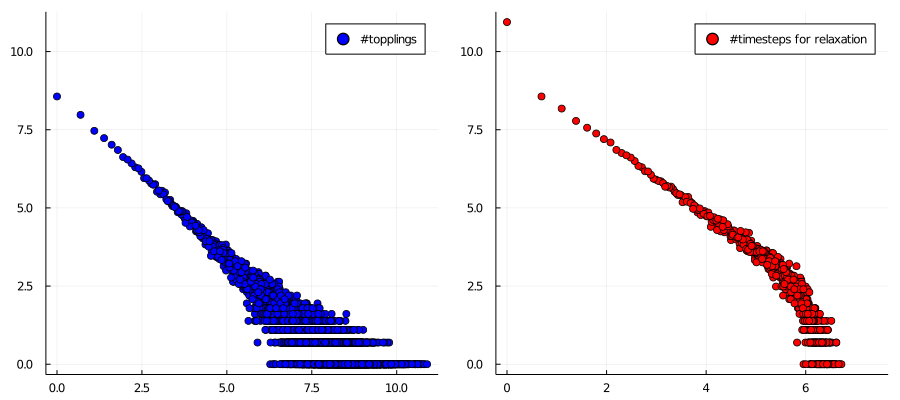

In [117]:
#times = filter(e->e≠0,data[:,2])
plts = []
cols = [:blue, :red]
lab = ["#topplings", "#timesteps for relaxation"]

for i in [2,3]
    xyax = countmap(data[:, i])
    xax = keys(xyax) .|> log
    yax = (i==2) ? (values(xyax) .|> log) : (values(xyax) .-1 .|> log)
    push!(plts, scatter(xax, yax, color = cols[i-1], label = lab[i-1]))
end

plot(plts[1], plts[2], size = (900,400))

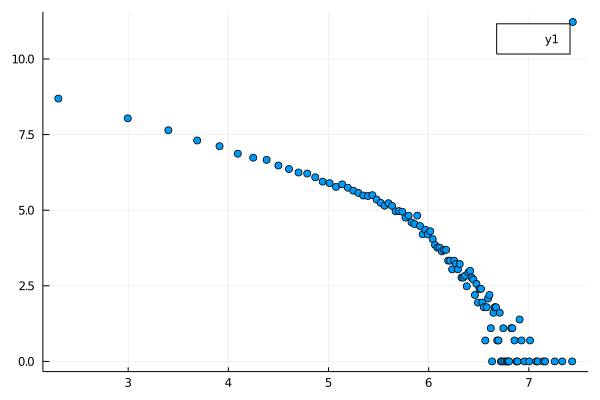

In [132]:
h = fit(Histogram, data[:, 3], nbins = 300)
xax = h.edges[1] .|> log
yax = h.weights .|> log
scatter(xax, yax)

-1.0885346382058554

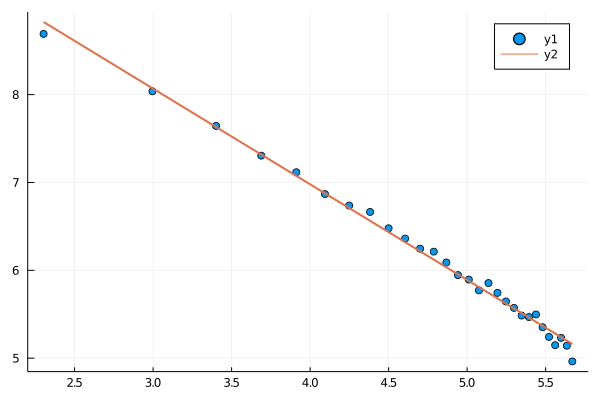

In [135]:
st = 2
lims = 30
m(x, p) = p[1] .* x .+ p[2]
p0 = [-1.0, 5]
res = curve_fit(m, xax[st:lims], yax[st:lims], p0)
mres(x) = m(x, res.param)
print(res.param[1])

scatter(xax[st:lims], yax[st:lims])
plot!(xax[st:lims], mres.(xax[st:lims]), lw = 2)